# NN4: Rozwiązywanie zadania klasyfikacji
## Laura Hoang, 313366

Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. **Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.**

Przeprowadzić eksperymenty na zbiorach (w nawiasach wymagana wartość F-measure na 2 punkty):
- rings3-regular (F-measure: 0.75),
- easy (F-measure: 0.99),
- xor3 (F-measure: 0.97).

## Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from numpy import dot, square, subtract
from scipy.special import expit
import matplotlib
from matplotlib import pyplot as plt

np.random.seed(420)

## Implementacja sieci

### Funkcje aktywacji

In [2]:
def softmax(x):
    e_x = np.exp(x.T - np.max(x, axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T

def sigmoid(x):
    return expit(x)  # wersja stabilna numerycznie

# pochodna funkcji sigmoid
def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))


### Metryki

In [3]:
## REGRESJA
# błąd średniowkadratowy
def mse(y, y_hat):
    return square(subtract(y, y_hat)).mean()

## KLASYFIKACJA
def TP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a==b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FP(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(b==v) for (a,b) in zip(y,y_hat)]]
    return result

def FN(y,y_hat):
    vals = np.unique(y)
    result = []
    for v in vals:
        result += [[(a!=b)and(a==v) for (a,b) in zip(y,y_hat)]]
    return result

# Precision = tp / (tp + fp)
def precision(y,y_hat):
    tp = TP(y,y_hat)
    fp = FP(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fp = sum([sum(x) for x in fp])
    return sum_tp / (sum_tp + sum_fp)

# Recall = tp / (tp + fn)
def recall(y,y_hat):
    tp = TP(y,y_hat)
    fn = FN(y,y_hat)
    sum_tp = sum([sum(x) for x in tp])
    sum_fn = sum([sum(x) for x in fn])
    return sum_tp / (sum_tp + sum_fn)

# Poor F-Measure score is 0.0 and a best or perfect F-Measure score is 1.0
# F-Measure = (2 * Precision * Recall) / (Precision + Recall)
def f_measure(y,y_hat):
    pre = precision(y,y_hat)
    rec = recall(y,y_hat)
    return (2 * pre * rec) / (pre + rec)

### Sieć neuronowa

In [4]:
class NeuralNetwork():
    def __init__(self, number_of_neurons=[], activation=sigmoid, activation_der=sigmoid_der, initiate_w_b="Uniform", use_softmax=False):
        # activation - funkcja aktywacji: sigmoid(default)
        # activation_der - pochodna funkcji aktywacji: sigmoid_der(default)
        # initiate_w_b - ustalanie metody inicjowania począkowych wag (i biasów): Uniform(default) / Xavier

        self.number_of_neurons = number_of_neurons  # liczba neuronów w każdej warstwie (wliczając wejście i wyjście)
        self.synaptic_weights = []                  # lista z wagami
        self.biases = []                            # lista biasów

        self.activation = activation
        self.activation_der = activation_der

        if initiate_w_b == "Xavier":
            self.weights_xavier(number_of_neurons)
        else:
            self.weights_uniform(number_of_neurons)

        self.use_softmax = use_softmax


    def weights_uniform(self, number_of_neurons):
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def weights_xavier(self, number_of_neurons):
        xavier = np.sqrt(6)/np.sqrt(self.number_of_neurons[1]+self.number_of_neurons[-1])
        for i in range(len(self.number_of_neurons) - 1):
            self.synaptic_weights += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i] * self.number_of_neurons[i + 1]).reshape(number_of_neurons[i], self.number_of_neurons[i + 1])]
            self.biases += [xavier * np.random.uniform(-1, 1, self.number_of_neurons[i + 1]).reshape(1, self.number_of_neurons[i+1])]


    def forward(self, input):
        self.A = []
        self.z = []

        self.A += [input]
        a = input

        number_of_hidden_layers = len(self.number_of_neurons)-2
        for layer in range(number_of_hidden_layers):
            output = dot(a, self.synaptic_weights[layer]) + self.biases[layer]
            self.z += [output]
            a = self.activation(output)
            self.A += [a]
        result = dot(a,self.synaptic_weights[-1]) + self.biases[-1]

        if self.use_softmax:
            result = softmax(result)

        self.z += [result]
        self.A += [result]

        return result


    def backward(self, y):
        m = y.shape[0]
        D = [None] * len(self.synaptic_weights)

        if self.use_softmax:
            tmp = []
            for a,y_ in zip(self.A[-1], y):
                error = y_-a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.number_of_neurons[-1], 1)
                sof_der = np.diag(a_) + si_sj
                tmp += [dot(sof_der,error)]
            tmp = np.array(tmp)
            D[-1] = tmp
        else:
            D[-1] = (y - self.A[-1]) * self.activation_der(self.A[-1])

        for i in reversed(range(len(D) - 1)):
            D[i] = (dot(self.synaptic_weights[i + 1], D[i + 1].T) * self.activation_der(self.z[i]).T).T

        delta_w = [None] * len(D)
        delta_b = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = dot(d.T, self.A[i]).T / m
            delta_b[i] = dot(d.T, np.ones((m, 1))).T / m

        return (delta_w, delta_b)


    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, method = "Classic", var=0.4):
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        method_w = [np.zeros(w.shape) for w in self.synaptic_weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            while i < len(y):
                x_batch = x[i : i+batch_size]
                y_batch = y[i : i+batch_size]

                i += batch_size
                self.forward(x_batch)
                (delta_w, delta_b) = self.backward(y_batch)

                if method == "Classic":
                    for j, weight in enumerate(self.synaptic_weights):
                        self.synaptic_weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.synaptic_weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.synaptic_weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.synaptic_weights):
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.synaptic_weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)


    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]



### Wizualizacje

In [5]:
def plot_train_test(x, y, c, x_test, y_test, c_test):
    colors = ['pink','lightgreen','lightblue']
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Zbiór treningowy vs. testowy')
    fig.set_size_inches(12,5)
    ax1.scatter(x, y, c=c, cmap=matplotlib.colors.ListedColormap(colors))
    ax2.scatter(x_test, y_test, c=c_test, cmap=matplotlib.colors.ListedColormap(colors))

def plot_compare_pred(x,y,c,c1,c2):
    colors = ['pink','lightgreen','lightblue']

    fig = plt.figure(figsize=(8,8))

    plt.subplot(2, 2, 1)
    plt.scatter(x, y, c=c, cmap=matplotlib.colors.ListedColormap(colors))
    plt.title('Oryginalny podział')

    plt.subplot(2, 2, 3)
    plt.scatter(x, y, c=c1, cmap=matplotlib.colors.ListedColormap(colors))
    plt.title('Bez softmax')

    plt.subplot(2, 2, 4)
    plt.scatter(x, y, c=c2, cmap=matplotlib.colors.ListedColormap(colors))
    plt.title('Softmax')

    print("Bez softmax:",f_measure(c, c1), "Softmax:",f_measure(c, c2))


### Funkcje pomocnicze

In [6]:
def one_hot(c):
    unique_vals = np.unique(c)
    tmp=[]
    for val in unique_vals:
        tmp += [((c==val)*1).tolist()]
    return tmp

## Pierwszy zbiór danych (*rings3-regular*)

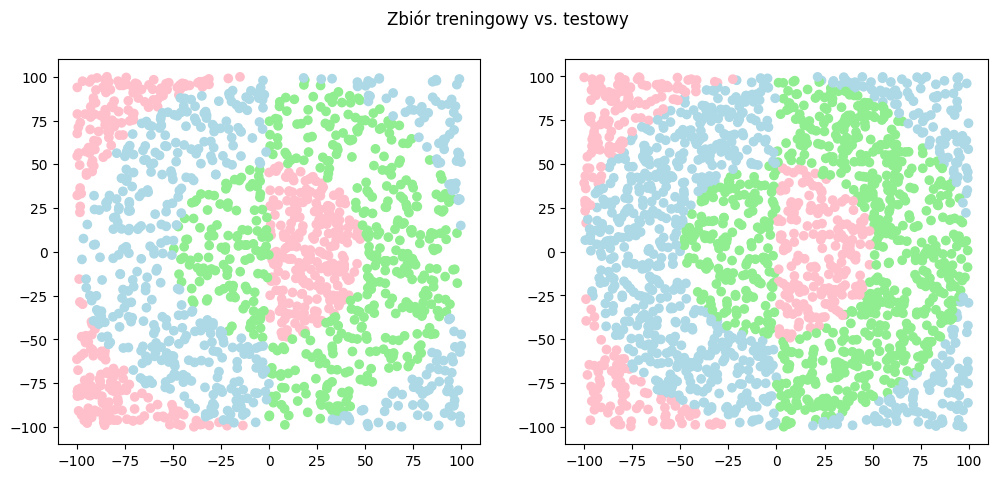

In [14]:
train_df = pd.read_csv('rings3-regular-training.csv')
test_df = pd.read_csv('rings3-regular-test.csv')

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [15]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

In [16]:
number_of_neurons = [2, 64, 64, 3]

nn = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=False)
nn.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

nn_softmax = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=True)
nn_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 1000)

Bez softmax: 0.7940000000000002 Softmax: 0.786
Bez softmax: 0.7495 Softmax: 0.7595


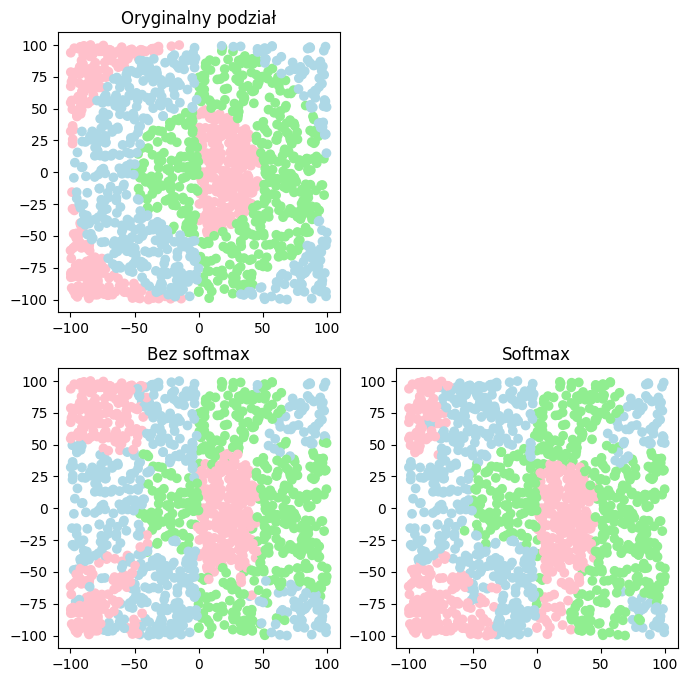

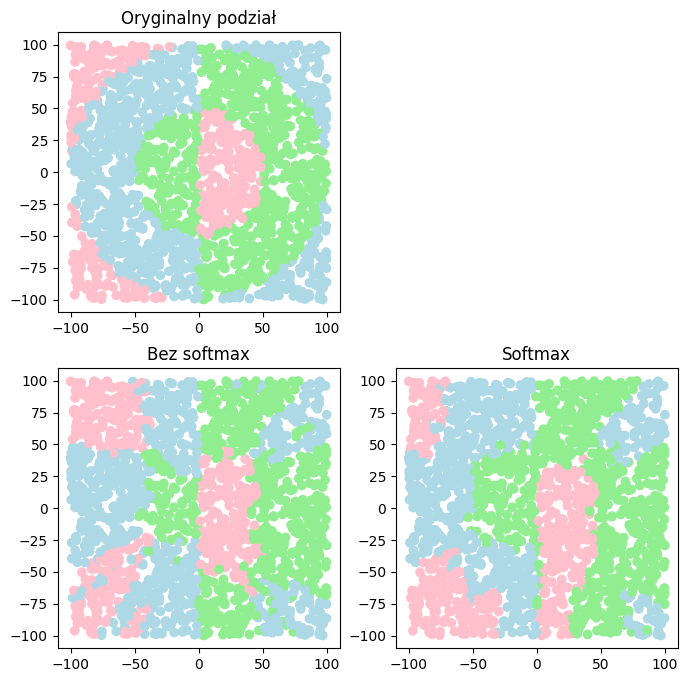

In [18]:
plot_compare_pred(train_df['x'], train_df['y'], train_df['c'], nn.classify(x), nn_softmax.classify(x))

plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], nn.classify(x_test), nn_softmax.classify(x_test))

## Drugi zbiór danych (*easy*)

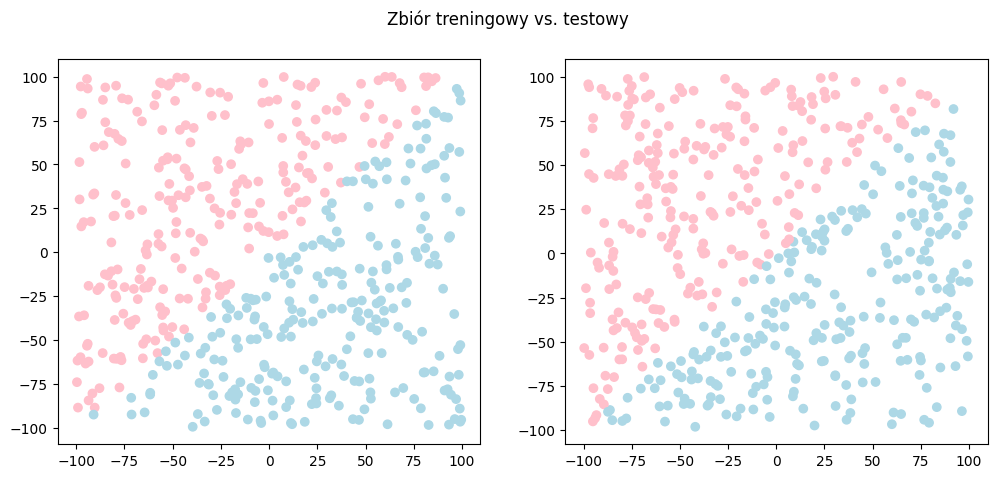

In [11]:
train_df = pd.read_csv('easy-training.csv')
test_df = pd.read_csv('easy-test.csv')

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [12]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

In [13]:
number_of_neurons = [2, 20, 2]
nn = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=False)
nn.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

nn_softmax = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=True)
nn_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

KeyboardInterrupt: 

Bez softmax: 0.998 Softmax: 1.0


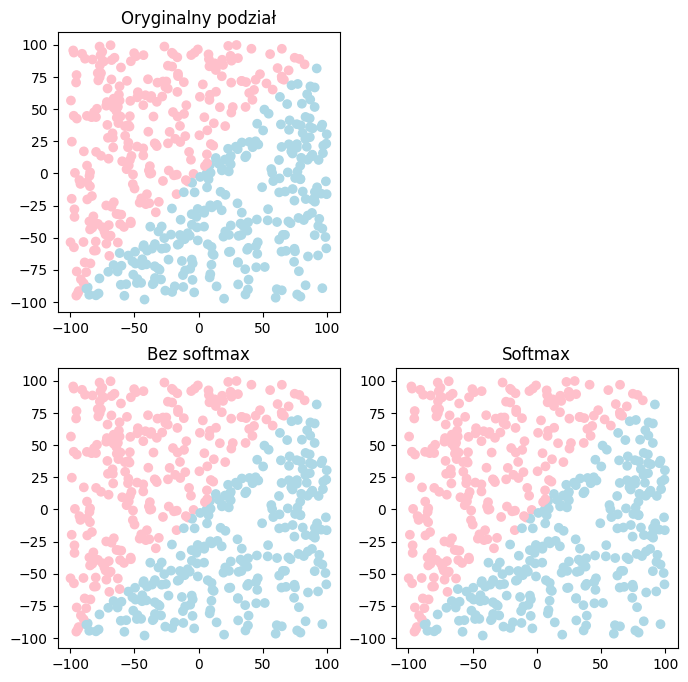

In [ ]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], nn.classify(x_test), nn_softmax.classify(x_test))

## Trzeci zbiór danych (*xor3*)

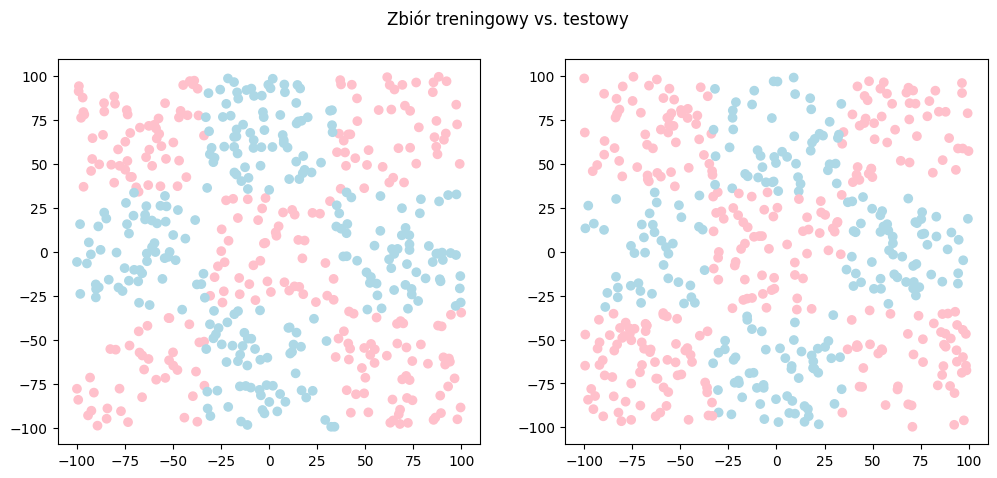

In [ ]:
train_df = pd.read_csv('xor3-training.csv')
test_df = pd.read_csv('xor3-test.csv')

plot_train_test(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [ ]:
x = np.asarray(train_df[['x', 'y']])
x_test = np.asarray(test_df[['x', 'y']])

c = np.asarray(train_df['c'])
c_test = np.asarray(test_df['c'])

encoded = np.array(one_hot(c)).T

In [ ]:
number_of_neurons = [2, 100, 100, 100, 2]

nn = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=False)
nn.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

nn_softmax = NeuralNetwork(number_of_neurons=number_of_neurons, activation=sigmoid, activation_der=sigmoid_der, use_softmax=True)
nn_softmax.learn(x = x, y = encoded, alpha = 0.01, iterations = 3000, method = "Momentum", var =0.5)

Bez softmax: 0.87 Softmax: 0.8759999999999999


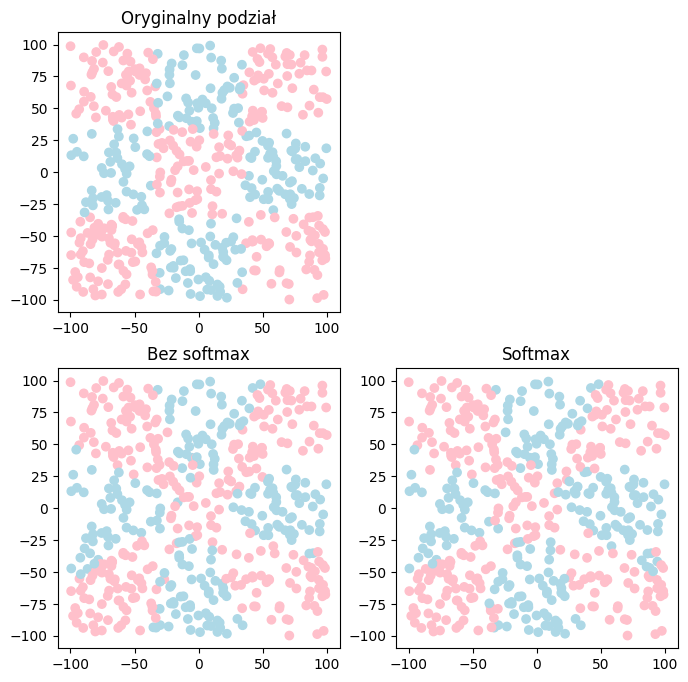

In [ ]:
plot_compare_pred(test_df['x'], test_df['y'], test_df['c'], nn.classify(x_test), nn_softmax.classify(x_test))

## Podsumowanie

Wartości **F-measure**:
| Zbiór danych | Bez softmax | Softmax |
|--------------|--------|--------|
| rings3-regular | 0.7015 | 0.819 |
| easy | 0.998 | 1.0 |
| xor3 | 0.87 | 0.876 |